In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [3]:
os.chdir('..')

In [4]:
import pickle

from hydra import compose, initialize
from omegaconf import OmegaConf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from tqdm.notebook import tqdm

from src.preprocessing import preprocessing
from src.datamodules.autoencoder import AEDataModule
from src.networks.lstm import LSTMAE

%load_ext autoreload
%autoreload 2

In [5]:
BEST_MODEL_PATH = 'logs/lstm/checkpoints/lstm__embed_dim64_num_layers_1.ckpt'

In [11]:
with initialize(config_path='../config', version_base=None):
    cfg = compose(config_name='config')
cfg_preprop = cfg['dataset']
cfg_model = cfg['autoencoder']

In [14]:
seq_data, data_srt = preprocessing(cfg_preprop['name'])(cfg_preprop, return_preproc=True)

In [25]:
seq_data = pd.read_parquet('data/new_data/old_preprop/agg_dataset.parquet')

In [26]:
datamodule = AEDataModule(
        None,
        seq_data,
        cfg_preprop['user_column'],
        cfg_preprop['mcc_column'],
        cfg_preprop['transaction_amt_column'],
        cfg_model['data_split']['val_size'],
        1,
        cfg_preprop['preproc']['len_max'],
        4,
        .5,
        False,
        binarize=False
    )

In [27]:
datamodule.setup('test')
dataloader = datamodule.test_dataloader()

In [21]:
best_model = LSTMAE.load_from_checkpoint(BEST_MODEL_PATH,
                                         use_user_embedding=None,
                                         user_embedding_size=None,
                                         use_masked_prediction=None,
                                         rand_rate=None,
                                         mask_token=None,
                                         core_ae=None)

TypeError: 'NoneType' object is not subscriptable

-------------

In [15]:
test_batch = next(iter(dataloader))

In [16]:
test_batch

(tensor([1]),
 tensor([[1, 2, 3, 4, 4, 5, 4, 6, 4, 1, 5, 4, 7, 2, 1, 4, 8, 1, 2, 2, 1, 1, 1, 2,
          2, 3]]),
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[ 7.7169, 10.9357, 10.9357,  7.2388,  6.8253,  9.5917,  6.9184,  7.9480,
           6.4439,  8.6332,  9.5917,  8.1487,  9.9941,  8.4100,  7.0237,  6.4439,
          12.3220,  7.7169, 10.7126,  8.4100,  7.7169,  7.7169,  7.7169, 11.8913,
          13.7083, 10.0195]]),
 tensor([26]),
 tensor([1.]))

In [27]:
with torch.no_grad():
    _, _, info = best_model.predict_step(test_batch, 0)

tensor([[False,  True, False, False, False,  True,  True, False,  True, False,
         False, False, False, False,  True, False,  True, False, False,  True,
         False]])


In [28]:
info[2]

tensor([[5.9388, 5.3770, 4.8621, 6.0998, 5.3534, 5.3724, 5.2077, 5.1640, 5.6322,
         5.7309, 4.8312, 5.5309, 5.3607, 5.4170, 5.5181, 3.1517, 5.2182, 4.3342,
         5.6637, 4.9317, 3.6922]])

In [35]:
info[0].max(dim=1)

torch.return_types.max(
values=tensor([[ 4.0718,  3.9179, 23.4038, 15.8391, 11.3016, 21.4676,  5.8177, 10.0803,
          7.4759,  7.1180,  6.7755,  6.6837,  6.5924,  6.5210,  6.8281,  9.2772,
          9.5451,  7.0043, 10.5147, 16.5846, 20.4851]]),
indices=tensor([[1, 1, 2, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 2, 7, 1, 4]]))

----------------

In [28]:
if not os.path.exists('data/gender_data/results/'):
    os.mkdir('data/gender_data/results/')

if not os.path.exists(
    f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}.npy'
):
    results = np.zeros((len(dataloader), 5), dtype=np.float32)

    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            outputs = best_model.predict_step(batch, i)
            results[i, 0] = batch[-1].cpu().numpy()
            results[i, 1] = outputs[0].cpu().numpy()
            results[i, 2:] = np.array(outputs[1])
    np.save(
        f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}',
        results
    )
else:
    results = np.load(
        f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}.npy'
    )


In [29]:
results

array([[0.0000000e+00, 5.8996287e-04, 7.3414310e-05, 1.9821542e-07,
        4.9672701e-04],
       [2.5641026e-02, 1.6412984e-03, 1.4189981e-04, 1.1966280e-06,
        1.3797358e-03],
       [0.0000000e+00, 5.4374192e-04, 6.6896609e-05, 4.9191601e-07,
        4.2765372e-04],
       ...,
       [0.0000000e+00, 2.7134517e-04, 2.2178154e-05, 4.8992728e-08,
        2.4426775e-04],
       [0.0000000e+00, 2.7532619e-04, 1.5309244e-05, 4.6279162e-08,
        2.5538902e-04],
       [0.0000000e+00, 6.9053221e-04, 2.2241935e-05, 1.2244726e-07,
        6.5604557e-04]], dtype=float32)

In [30]:
results = np.concatenate((seq_data.index.values[:, np.newaxis], results), 1)

In [31]:
results

array([[0.00000000e+00, 0.00000000e+00, 5.89962874e-04, 7.34143105e-05,
        1.98215417e-07, 4.96727007e-04],
       [1.00000000e+00, 2.56410260e-02, 1.64129841e-03, 1.41899814e-04,
        1.19662798e-06, 1.37973577e-03],
       [2.00000000e+00, 0.00000000e+00, 5.43741917e-04, 6.68966095e-05,
        4.91916012e-07, 4.27653722e-04],
       ...,
       [4.81241000e+05, 0.00000000e+00, 2.71345169e-04, 2.21781538e-05,
        4.89927281e-08, 2.44267751e-04],
       [4.81242000e+05, 0.00000000e+00, 2.75326194e-04, 1.53092442e-05,
        4.62791618e-08, 2.55389023e-04],
       [4.81243000e+05, 0.00000000e+00, 6.90532208e-04, 2.22419349e-05,
        1.22447261e-07, 6.56045566e-04]])

In [32]:
anomaly_fraq = np.unique(results[:, 1])

In [33]:
losses = []
for fraq in tqdm(anomaly_fraq):
    losses.append(results[np.argwhere(results[:, 1] == fraq)][:, 0, :])

  0%|          | 0/534 [00:00<?, ?it/s]

In [34]:
losses = np.concatenate(losses)
losses_df = pd.DataFrame(losses, columns=['seq_id', 'anomaly_fraq', 'loss', 'mcc_loss', 'binary_loss', 'amt_loss'])

In [35]:
losses_df['seq_id'] = losses_df['seq_id'].astype(np.int32)
losses_df.set_index('seq_id', inplace=True)

In [36]:
losses_df['loss_sum'] = losses_df['mcc_loss'] + losses_df['binary_loss'] + losses_df['amt_loss']

In [37]:
def make_groups(fraq):
    if fraq < .2:
        return 0
    elif .2 <= fraq < .5:
        return 1
    elif .5 <= fraq < .7:
        return 2
    else:
        return 3
    
losses_df['class'] = losses_df['anomaly_fraq'].apply(make_groups)

In [38]:
agg_df = pd.DataFrame(losses_df.groupby('anomaly_fraq').agg({
    'loss': ['mean', 'std'],
    'mcc_loss': ['mean', 'std'],
    'binary_loss': ['mean', 'std'],
    'amt_loss': ['mean', 'std'],
    'loss_sum': ['mean', 'std']
}))

<Axes: xlabel='loss_sum', ylabel='Count'>

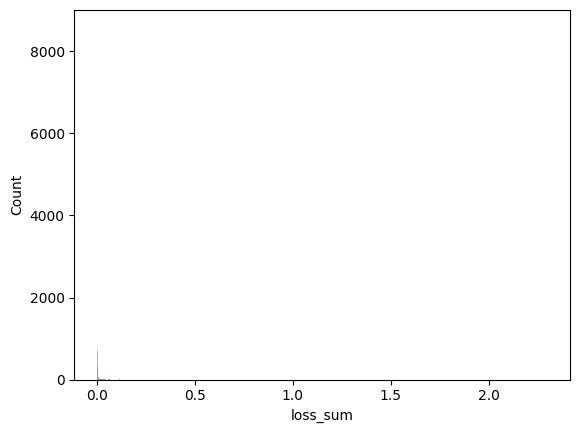

In [39]:
sns.histplot(losses_df[(losses_df['anomaly_fraq'] == 0)]['loss_sum'])
sns.histplot(losses_df[(losses_df['anomaly_fraq'] > 0)]['loss_sum'])

Text(0, 0.5, 'loss')

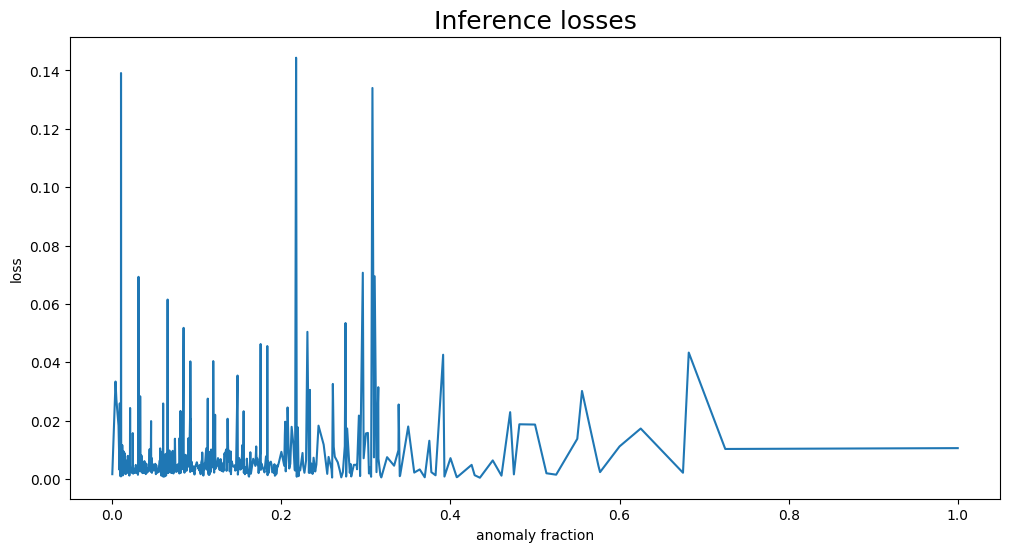

In [55]:
plt.figure(figsize=(12, 6))

plt.plot(agg_df.index, agg_df['loss_sum']['mean']);
plt.title('Inference losses', fontsize=18)
plt.xlabel('anomaly fraction', fontsize=10)
plt.ylabel('loss', fontsize=10)

In [41]:
losses_df['loss_sum']

seq_id
0         0.000570
2         0.000495
3         0.001036
5         0.001434
6         0.001146
            ...   
146891    0.009563
233111    0.060796
313794    0.001090
330356    0.000262
416643    0.000367
Name: loss_sum, Length: 481243, dtype: float64

In [42]:
losses_df[losses_df['anomaly_fraq'] >= .5]['loss_sum'].max()

0.18763748678611591

In [43]:
from sklearn.metrics import precision_recall_curve

In [44]:
def get_optimum_threshold(y_true, y_pred_proba):
    precisions, recalls, trs = precision_recall_curve(
        y_true, y_pred_proba
    )

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    print(f1_scores.max())
    plt.plot(precisions, recalls)
    plt.show()

    return trs[np.argmax(f1_scores)]

In [45]:
y_true = losses_df['anomaly_fraq'] >= .5

nan


/tmp/ipykernel_3182/1252276051.py:6: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


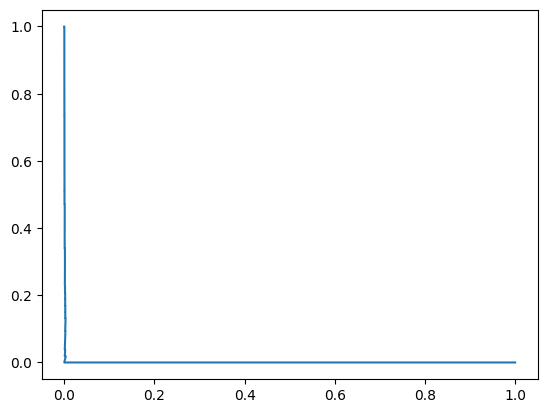

In [46]:
tr = get_optimum_threshold(y_true, losses_df['loss_sum'].values)

<BarContainer object of 100 artists>

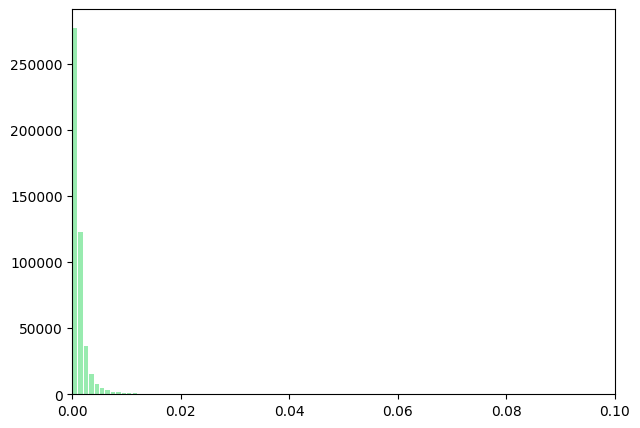

In [47]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_df[losses_df['loss'] < .1]['loss']

# Get histogram
hist, bins = np.histogram(x, bins=100)
# hist = hist / np.sum(hist)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0, 0.1])
#plt.margins(0.05)
plt.bar(center, hist, align='center', width=width, color = '#33D860', label='normal', alpha=0.5)

<Axes: xlabel='loss_sum'>

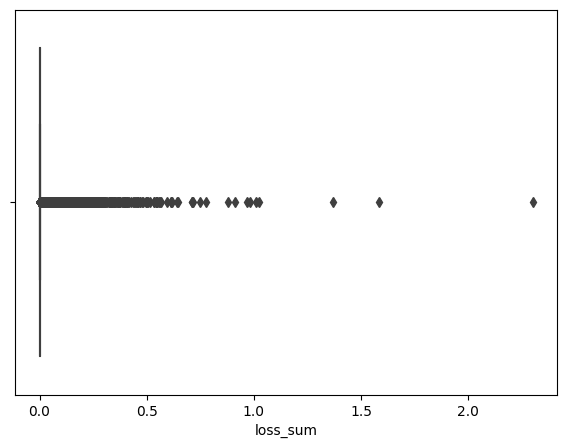

In [48]:
sns.boxplot(x=losses_df['loss_sum'])

Важно! Модель посчитала аномалией набор транзакций с азартными играми (7995 - азартные игры)

user_id - 10682

seq_index - 228781

In [162]:
losses_df[losses_df['loss_sum'] > 20]

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,loss_sum,class
seq_id,,,,,,,
106900,0.0,23.073166,3.290904,0.020689,17.713409,21.025002,0
114053,0.0,27.821541,3.920145,0.020689,21.832542,25.773376,0
168182,0.0,24.901468,3.920145,0.020689,18.912470,22.853303,0
192826,0.0,45.919579,1.038726,0.223977,22.483152,23.745856,0
257582,0.0,22.851784,7.075835,0.020689,13.707093,20.803617,0
375812,0.0,53.783756,0.550530,0.331436,20.089630,20.971596,0
375810,0.5,23.261929,6.309790,0.020701,14.882029,21.212520,2
233111,1.0,33.193787,6.796909,0.020689,24.328026,31.145624,3


In [168]:
seq_data.loc[375812]['mcc_code']

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11])

In [91]:
np.exp(seq_data.iloc[228781]['transaction_amt'])

array([ 22.640741, 109.61357 , 104.53754 ,  46.06033 , 146.29277 ,
       906.0762  , 615.7704  ,  42.93056 ,  45.062397,  53.22185 ,
       106.4844  ,  49.638184,  41.42833 , 108.79991 ,  43.768253,
        91.294975,  26.3708  ,  46.409595,  74.03558 , 299.65143 ,
        52.786674,  55.04169 ,  47.810593,  42.436966,  92.17858 ,
        92.656   ,  90.42266 ,  45.48023 ,  54.039265,  55.719685,
       108.61172 , 108.3005  ,  52.05275 , 104.6088  , 165.3661  ,
        94.977066, 443.53137 ,  93.68741 ,  26.717432,  94.710556])

In [169]:
with open('data/new_data/preprocessed/mcc2id.dict', 'rb') as f:
    with open('data/new_data/preprocessed/user2id.dict', 'rb') as f_1:
        mcc2id = dict(pickle.loads(f.read()))
        user2id = dict(pickle.loads(f_1.read()))

In [170]:
id2mcc = {}
id2user = {}
for k, v in mcc2id.items():
    id2mcc[v] = k
for k, v in user2id.items():
    id2user[v] = k

In [171]:
id2mcc[11]

6011

In [92]:
losses_df[losses_df['loss'] > 1]

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,class
27003,0.000,2.301008,1.652921,1.368638e-06,0.647950,0
152523,0.000,1.026022,1.024961,8.510493e-08,0.001053,0
190996,0.000,1.750069,0.000349,1.661448e-02,0.088273,0
228781,0.000,8.238477,0.000121,8.231580e-02,0.006775,0
336094,0.000,1.584863,1.581835,1.119445e-06,0.002917,0
463958,0.075,1.010901,0.997991,1.396667e-06,0.012770,0
472099,0.100,1.370712,1.360427,1.221470e-06,0.010163,0


In [105]:
seq_data.iloc[152523]['mcc_code']

array([ 4, 27,  4, 17, 11, 11,  1,  1,  1,  4,  4,  4, 29, 27, 10,  1,  4,
        3,  1, 27, 79,  4,  4, 45, 45,  1,  1, 83, 20, 10,  9,  9, 83,  4,
        4, 10,  4,  4,  1, 10])

In [106]:
np.exp(seq_data.iloc[152523]['transaction_amt'])

array([  105.706215,   453.6131  ,   637.0809  ,  2113.6567  ,
        3734.1477  ,  5319.124   ,   577.4285  ,   452.62314 ,
        1194.3778  ,    45.360874,   177.24718 ,    93.19953 ,
        2469.5986  ,   827.13464 ,   207.84126 ,   937.9837  ,
         106.322   , 14444.672   ,   669.1018  ,   465.40512 ,
         848.62244 ,    92.386734,   172.4608  ,    18.137623,
         397.60193 ,   514.62616 ,   627.13965 ,  2120.0928  ,
        1160.5157  ,   179.77898 ,   105.38092 ,   789.8764  ,
         741.5316  ,   512.9007  ,    89.932335,    74.01915 ,
         108.026276,   108.19927 ,   787.0158  ,   214.07022 ])

In [107]:
id2mcc[45]

4121

In [79]:
orig_df = pd.read_parquet('data/new_data/transactions.parquet')

In [88]:
orig_df[(orig_df['user_id'] == id2user[10682]) & (orig_df['mcc_code'] == 7995)]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
9427255,782283ce1b594f618f8424fe25500c85,7995,48,-40.205284,2020-07-31 06:38:43
9427258,782283ce1b594f618f8424fe25500c85,7995,48,-36.907352,2020-08-01 06:45:14
9427259,782283ce1b594f618f8424fe25500c85,7995,48,-47.200695,2020-08-01 06:53:42
9427260,782283ce1b594f618f8424fe25500c85,7995,48,-36.507774,2020-08-01 07:27:25
9427262,782283ce1b594f618f8424fe25500c85,7995,48,-37.392696,2020-08-01 09:21:51
...,...,...,...,...,...
9428296,782283ce1b594f618f8424fe25500c85,7995,48,-90.043236,2021-01-24 03:22:03
9428297,782283ce1b594f618f8424fe25500c85,7995,48,-211.213870,2021-01-24 04:40:14
9428303,782283ce1b594f618f8424fe25500c85,7995,48,-22.310303,2021-01-26 14:16:54
9428304,782283ce1b594f618f8424fe25500c85,7995,48,-107.449690,2021-01-26 15:33:23
